In [89]:
import numpy as np
import networkx as nx
import igraph as ig
import random
from scipy.special import expit as sigmoid

# Import utility functions
from causal_helpers import set_random_seed

########################## DAG Sampling Functions ##########################

def sample_B(n_nodes, n_edges, graph_type, ws_nei=None, ws_p=None):
    """Simulate a random DAG with a specified number of nodes and edges.

    Parameters
    ----------
    n_nodes : int
        Number of nodes.
    n_edges : int
        Expected number of edges.
    graph_type : str
        Type of graph: "ER", "SF", "BP", or "WS".
    ws_nei : int, optional
        Number of neighbors for WS graph (default: max(2, n_nodes // 10)).
    ws_p : float, optional
        Rewiring probability for WS graph (default: 0.1).

    Returns
    -------
    B : array-like, shape (n_nodes, n_nodes)
        Binary adjacency matrix of the DAG.
    """

    def _random_permutation(M):
        """Apply a random permutation to adjacency matrix M."""
        P = np.random.permutation(np.eye(M.shape[0]))
        return P.T @ M @ P

    def _random_acyclic_orientation(B_und):
        """Convert undirected adjacency matrix to DAG by enforcing acyclicity."""
        return np.tril(_random_permutation(B_und), k=-1)

    def _graph_to_adjmat(G):
        """Convert an igraph graph to an adjacency matrix."""
        return np.array(G.get_adjacency().data)

    if graph_type == "ER":
        G_und = ig.Graph.Erdos_Renyi(n=n_nodes, m=n_edges)
        B_und = _graph_to_adjmat(G_und)
        B = _random_acyclic_orientation(B_und)

    elif graph_type == "SF":
        G = ig.Graph.Barabasi(n=n_nodes, m=int(round(n_edges / n_nodes)), directed=True)
        B = _graph_to_adjmat(G)

    elif graph_type == "BP":
        top = int(0.2 * n_nodes)
        G = ig.Graph.Random_Bipartite(top, n_nodes - top, m=n_edges, directed=True, neimode=ig.OUT)
        B = _graph_to_adjmat(G)

    elif graph_type == "WS":
        # Set default values for Watts-Strogatz parameters
        if ws_nei is None:
            ws_nei = max(2, n_nodes // 10)  # At least 2 neighbors, or 10% of nodes
        if ws_p is None:
            ws_p = 0.1  # Default rewiring probability

        G_und = ig.Graph.Watts_Strogatz(dim=1, size=n_nodes, nei=ws_nei, p=ws_p)
        B_und = _graph_to_adjmat(G_und)
        B = _random_acyclic_orientation(B_und)  # Ensure acyclicity

    else:
        raise ValueError("Unknown graph type. Choose from ['ER', 'SF', 'BP', 'WS'].")

    B_perm = _random_permutation(B)
    assert ig.Graph.Adjacency(B_perm.tolist()).is_dag(), "Generated graph is not a DAG!"
    return B_perm


def is_dag(W):
    """Check if B is a dag or not.

    Parameters
    ----------
    B : array-like, shape (n_nodes, n_nodes)
        Binary adjacency matrix of DAG, where ``n_nodes``
        is the number of features.

    Returns
    -------
     G: boolean
        Returns true or false.

    """
    G = ig.Graph.Weighted_Adjacency(B.tolist())
    return G.is_dag()

def simulate_parameter(B, w_ranges=((-2.0, -0.5), (0.5, 2.0))):
    """Simulate SEM parameters for a DAG.

    Parameters
    ----------
    B : array-like, shape (d, d)
        Binary adjacency matrix of DAG, where ``d``
        is the number of features.
    w_ranges : tuple
        Disjoint weight ranges.

    Returns
    -------
    W : array-like, shape (d, d)
        Weighted adj matrix of DAG, where ``d``
        is the number of features.
    """

    W = np.zeros(B.shape)
    S = np.random.randint(len(w_ranges), size=B.shape)  # which range
    for i, (low, high) in enumerate(w_ranges):
        U = np.random.uniform(low=low, high=high, size=B.shape)
        W += B * (S == i) * U
    return W

def simulate_linear_mixed_sem(
    W, n_samples, sem_type, is_cont, noise_scale=None
):
    """Simulate mixed samples from linear SEM with specified type of noise.

    Parameters
    ----------
    W : array-like, shape (n_nodes, n_nodes)
        Weighted adjacency matrix of DAG, where ``n_nodes``
        is the number of variables.
    n_samples : int
        Number of samples. n_samples=inf mimics population risk.
    sem_type : str
        SEM type. gauss, mixed_random_i_dis.
    is_cont : array-like, shape (1, n_nodes)
        Indicator of discrete/continuous variables, where "1"
        indicates a continuous variable, while "0" a discrete
        variable.
    noise_scale : float
        scale parameter of additive noise.

    Returns
    -------
    X : array-like, shape (n_samples, n_nodes)
        Data generated from linear SEM with specified type of noise,
        where ``n_nodes`` is the number of variables.
    """

    def _simulate_single_equation(X, w, scale, is_cont_j):
        """Simulate samples from a single equation.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_nodes_parents)
            Data of parents for a specified variable, where
            n_nodes_parents is the number of parents.
        w : array-like, shape (1, n_nodes_parents)
            Weights of parents.
        scale : scale parameter of additive noise.
        is_cont_j : indicator of the j^th variable. If 1, the variable is continuous; if 0, the variable is discrete.

        Returns
        -------
        x : array-like, shape (n_samples, 1)
                    Data for the specified variable.
        """
        if sem_type == "gauss": # fully continuous SEM
            z = np.random.normal(scale=scale, size=n_samples)
            x = X @ w + z
        elif sem_type == "mixed_random_i_dis": # mixed SEM with some continuous and some discrete variables
            # randomly generated with fixed number of discrete variables.
            if is_cont_j:  # 1:continuous;   0:discrete

                # option A (Laplace)
                #z = np.random.laplace(0, scale=scale, size=n_samples) # Laplace noise (non-Gaussian assumption for lingam based methods)

                # option B (softplus(Normal))
                z = np.random.normal(scale=scale, size=n_samples)   # Softplus(Normal) noise as done in csuite benchmark, also non-Gaussian
                z = np.log(1 + np.exp(z))
                x = X @ w + z
            else:
                prob = (np.tanh(X @ w) + 1) / 2
                x = np.random.binomial(1, p=prob) * 1.0 # whenever a variable j has no parents, then it is generated from a Bernoulli distribution with probability sigmoid(0)
        else:
            raise ValueError("unknown sem type")
        return x

    n_nodes = W.shape[0]
    if noise_scale is None:
        scale_vec = np.ones(n_nodes)
    elif np.isscalar(noise_scale):
        scale_vec = noise_scale * np.ones(n_nodes) # equal variances for all variables
    else:
        if len(noise_scale) != n_nodes:
            raise ValueError("noise scale must be a scalar or has length n_nodes")
        scale_vec = noise_scale
    if not is_dag(W):
        raise ValueError("W must be a DAG")
    if np.isinf(n_samples):  # population risk for linear gauss SEM
        if sem_type == "gauss":
            # make 1/n_nodes X'X = true cov
            X = (
                np.sqrt(n_nodes)
                * np.diag(scale_vec)
                @ np.linalg.inv(np.eye(n_nodes) - W)
            )
            return X
        else:
            raise ValueError("population risk not available")
    # empirical risk
    G = ig.Graph.Weighted_Adjacency(W.tolist())
    ordered_vertices = G.topological_sorting()
    assert len(ordered_vertices) == n_nodes
    X = np.zeros([n_samples, n_nodes])
    for j in ordered_vertices:
        parents = G.neighbors(j, mode=ig.IN)
        # X[:, j] = _simulate_single_equation(X[:, parents], W[parents, j], scale_vec[j])
        X[:, j] = _simulate_single_equation(
            X[:, parents], W[parents, j], scale_vec[j], is_cont[0, j]
        )
    return X

# write some code to test the graph generation functions produce DAGs

d = 10
for i in range(5):
    B = sample_B(n_nodes=d, n_edges=4*d, graph_type="ER")
    print(is_dag(B))
    print(B.shape)

print("B using ER:\n", B)

for i in range(5):
    B = sample_B(n_nodes=d, n_edges=4*d, graph_type="SF")
    print(is_dag(B))
    print(B.shape)

print("B using SF:\n", B)

for i in range(5):
    B = sample_B(n_nodes=d, n_edges=d, graph_type="BP")
    print(is_dag(B))
    print(B.shape)

print("B using BP:\n", B)

for i in range(5):
    B = sample_B(n_nodes=d, n_edges=4*d, graph_type="WS")
    print(is_dag(B))
    print(B.shape)

print("B using WS:\n", B)

True
(10, 10)
True
(10, 10)
True
(10, 10)
True
(10, 10)
True
(10, 10)
B using ER:
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 1. 1. 1. 0. 0.]
 [1. 0. 1. 1. 0. 1. 1. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]]
True
(10, 10)
True
(10, 10)
True
(10, 10)
True
(10, 10)
True
(10, 10)
B using SF:
 [[0. 0. 1. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 1. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 1. 0. 0. 0. 0. 1. 1. 1.]
 [1. 0. 1. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 1. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 1. 0.]]
True
(10, 10)
True
(10, 10)
True
(10, 10)
True
(10, 10)
True
(10, 10)
B using BP:
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 

In [90]:
W = simulate_parameter(B)
print(is_dag(W))

True


In [91]:
n_samples, d, n_edges, graph_type, sem_type = 1000, 10, 20, 'WS', 'mixed_random_i_dis'
B = sample_B(d, n_edges, graph_type)
W = simulate_parameter(B)

In [92]:
n_disc = np.random.randint(1, d)  # number of discrete vars.
print('There are %d discrete variable(s).' % (n_disc))
nodes = [idx for idx in range(d)]
dis_var = random.sample(nodes, n_disc) # randomly select n_disc discrete variables
is_cont = np.full((1, d), np.inf) # just a placeholder
for idx in range(d):
    # 1:continuous;   0:discrete
    if idx in dis_var:
        is_cont[0, idx] = 0
    else:
        is_cont[0, idx] = 1

There are 2 discrete variable(s).


In [93]:
print(dis_var)
print(is_cont)

[3, 4]
[[1. 1. 1. 0. 0. 1. 1. 1. 1. 1.]]


In [94]:
X = simulate_linear_mixed_sem(W, n_samples, sem_type, is_cont)

In [95]:
# show X in a dataframe
import pandas as pd
df = pd.DataFrame(X)
display(df.describe())
# unique value counts for each column
for i in range(d):
    print(df[i].value_counts())

,0,1,2,3,4,5,6,7,8,9
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-1.249205,-2.079921,1.500704,0.041000,0.082000,0.819454,-1.809926,-0.073337,2.385118,-0.256021
std,1.924651,1.474227,0.695484,0.198389,0.274502,0.507282,2.666272,1.077364,1.125506,2.928296
min,-9.540400,-9.471294,0.214656,0.000000,0.000000,0.044270,-12.078444,-4.473706,0.390858,-9.735936
25%,-2.371145,-2.901171,0.983466,0.000000,0.000000,0.425156,-3.361282,-0.754343,1.564197,-2.060920
50%,-1.130229,-1.891880,1.372830,0.000000,0.000000,0.723335,-1.576760,-0.101484,2.184032,-0.155513
75%,0.008672,-1.029109,1.917306,0.000000,0.000000,1.095203,-0.043006,0.582421,2.972626,1.688872
max,4.432795,1.738807,4.316096,1.000000,1.000000,3.235988,5.592248,3.505269,8.013936,10.066088


-1.534673    1
-0.647891    1
-1.139652    1
-0.374559    1
 0.175516    1
            ..
-2.074623    1
-0.947014    1
-3.423512    1
 1.460823    1
-2.132905    1
Name: 0, Length: 1000, dtype: int64
-1.557972    1
-2.513731    1
-2.028291    1
-1.308835    1
-0.779238    1
            ..
-1.159091    1
-2.149657    1
-3.418384    1
-1.479056    1
-2.211709    1
Name: 1, Length: 1000, dtype: int64
0.911543    1
1.167541    1
1.007452    1
0.968196    1
0.927026    1
           ..
0.619959    1
0.947161    1
1.286655    1
1.977190    1
0.890500    1
Name: 2, Length: 1000, dtype: int64
0.0    959
1.0     41
Name: 3, dtype: int64
0.0    918
1.0     82
Name: 4, dtype: int64
0.403480    1
0.972208    1
0.803623    1
0.363897    1
0.325420    1
           ..
0.409015    1
0.440999    1
0.979576    1
0.412141    1
0.619733    1
Name: 5, Length: 1000, dtype: int64
-1.262492    1
 0.107591    1
-1.960369    1
-0.733277    1
 0.335387    1
            ..
-2.823924    1
-1.128290    1
-5.060099 

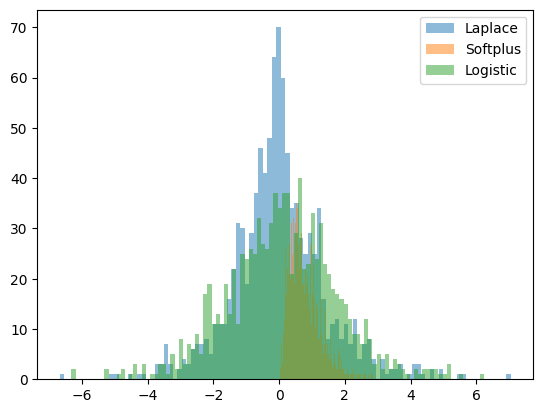

In [97]:
# write some code to compare and plot these three noise models
a = np.random.laplace(0, scale=1, size=1000)
b = np.random.normal(scale=1, size=1000)
b = np.log(1 + np.exp(b)) # softplus
c = np.random.logistic(loc=0, scale=1, size=1000)
import matplotlib.pyplot as plt
plt.hist(a, bins=100, alpha=0.5, label='Laplace')
plt.hist(b, bins=100, alpha=0.5, label='Softplus')
plt.hist(c, bins=100, alpha=0.5, label='Logistic')
plt.legend(loc='upper right')
plt.show()
